In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
import os
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print("Moving up to the parent directory")
print(os.getcwd())

The current directory is: 
c:\Users\nguye\Desktop\Crystal-Plasticity-COE-Course\notebooks
Moving up to the parent directory
c:\Users\nguye\Desktop\Crystal-Plasticity-COE-Course


In [2]:
import matplotlib.legend as mlegend
from matplotlib.patches import Rectangle

def tablelegend(ax, col_labels=None, row_labels=None, title_label="", *args, **kwargs):
    """
    Place a table legend on the axes.
    
    Creates a legend where the labels are not directly placed with the artists, 
    but are used as row and column headers, looking like this:
    
    title_label   | col_labels[1] | col_labels[2] | col_labels[3]
    -------------------------------------------------------------
    row_labels[1] |
    row_labels[2] |              <artists go there>
    row_labels[3] |
    
    
    Parameters
    ----------
    
    ax : `matplotlib.axes.Axes`
        The artist that contains the legend table, i.e. current axes instant.
        
    col_labels : list of str, optional
        A list of labels to be used as column headers in the legend table.
        `len(col_labels)` needs to match `ncol`.
        
    row_labels : list of str, optional
        A list of labels to be used as row headers in the legend table.
        `len(row_labels)` needs to match `len(handles) // ncol`.
        
    title_label : str, optional
        Label for the top left corner in the legend table.
        
    ncol : int
        Number of columns.
        

    Other Parameters
    ----------------
    
    Refer to `matplotlib.legend.Legend` for other parameters.
    
    """
    #################### same as `matplotlib.axes.Axes.legend` #####################
    handles, labels, extra_args, kwargs = mlegend._parse_legend_args([ax], *args, **kwargs)
    if len(extra_args):
        raise TypeError('legend only accepts two non-keyword arguments')
    
    if col_labels is None and row_labels is None:
        ax.legend_ = mlegend.Legend(ax, handles, labels, **kwargs)
        ax.legend_._remove_method = ax._remove_legend
        return ax.legend_
    #################### modifications for table legend ############################
    else:
        ncol = kwargs.pop('ncol')
        handletextpad = kwargs.pop('handletextpad', 0 if col_labels is None else -2)
        title_label = [title_label]
        
        # blank rectangle handle
        extra = [Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)]
        
        # empty label
        empty = [""]
        
        # number of rows infered from number of handles and desired number of columns
        nrow = len(handles) // ncol
        
        # organise the list of handles and labels for table construction
        if col_labels is None:
            assert nrow == len(row_labels), "nrow = len(handles) // ncol = %s, but should be equal to len(row_labels) = %s." % (nrow, len(row_labels))
            leg_handles = extra * nrow
            leg_labels  = row_labels
        elif row_labels is None:
            assert ncol == len(col_labels), "ncol = %s, but should be equal to len(col_labels) = %s." % (ncol, len(col_labels))
            leg_handles = []
            leg_labels  = []
        else:
            assert nrow == len(row_labels), "nrow = len(handles) // ncol = %s, but should be equal to len(row_labels) = %s." % (nrow, len(row_labels))
            assert ncol == len(col_labels), "ncol = %s, but should be equal to len(col_labels) = %s." % (ncol, len(col_labels))
            leg_handles = extra + extra * nrow
            leg_labels  = title_label + row_labels
        for col in range(ncol):
            if col_labels is not None:
                leg_handles += extra
                leg_labels  += [col_labels[col]]
            leg_handles += handles[col*nrow:(col+1)*nrow]
            leg_labels  += empty * nrow
        
        # Create legend
        ax.legend_ = mlegend.Legend(ax, leg_handles, leg_labels, ncol=ncol+int(row_labels is not None), handletextpad=handletextpad, **kwargs)
        ax.legend_._remove_method = ax._remove_legend
        return ax.legend_


In [3]:
# loadings = ["linear_uniaxial_RD", 
#             "nonlinear_biaxial_RD", 
#             "nonlinear_biaxial_TD",     
#             "nonlinear_planestrain_RD",     
#             "nonlinear_planestrain_TD",     
#             "nonlinear_uniaxial_RD", 
#             "nonlinear_uniaxial_TD"]
# start = 0
# end = 2000
# patchSize = 10
# pathPH = f"notebooks/PH"
# pathDB = f"notebooks/DB"

# for CPLaw in ["PH", "DB"]:
#     os.mkdir(f"notebooks/{CPLaw}")
#     for loading in loadings:
#         os.mkdir(f"notebooks/{CPLaw}/{loading}")
#         for i in range(0, 60, patchSize):
#             low = i
#             high = i + patchSize
#             os.mkdir(f"notebooks/{CPLaw}/{loading}/{low}-{high}")  

from math import * 

loadings = ["linear_uniaxial_RD", 
            "nonlinear_biaxial_RD", 
            "nonlinear_biaxial_TD",     
            "nonlinear_planestrain_RD",     
            "nonlinear_planestrain_TD",     
            "nonlinear_uniaxial_RD", 
            "nonlinear_uniaxial_TD"]

def preprocessExperimentalTrue(path, excel=False):
    if not excel:
        df = pd.read_csv(path, delimiter = "\t")
    else:
        df = pd.read_excel(path, usecols=["exp_strain","exp_stress"], engine="openpyxl")
    trueStrain = df["exp_strain"].to_numpy()
    trueStress = df["exp_stress"].to_numpy()
    return {"strain": trueStrain, "stress": trueStress}

def preprocessExperimentalFitted(path, excel=False):
    if not excel:
        df = pd.read_csv(path, delimiter = "\t")
    else:
        df = pd.read_excel(path, usecols=["fitted_strain","fitted_stress"], engine="openpyxl")
    fittedStrain = df["fitted_strain"].to_numpy()
    fittedStress = df["fitted_stress"].to_numpy()
    return {"strain": fittedStrain, "stress": fittedStress}

######################################################################
# Generalized Voce fitting equation [Ureta Xavier] #
######################################################################

# According to Ureta
# tau0 = 127.2 MPa
# tau1 = 124.2 MPa
# theta1 = 203.5 MPa
# theta0/tau1 = 17.74 => theta0 = 2203 MPa
# y = tau0 + (tau1 + theta1 * x) * (1 - exp(- x * abs(theta0/tau1)))

def preprocessSwiftVoceHardening(trueStrain, tau0, tau1, theta0, theta1):
    trueStress = tau0 + (tau1 + theta1 * np.array(trueStrain)) * (1 - np.exp(- np.array(trueStrain) * abs(theta0/tau1)))
    return {"strain": trueStrain, "stress": trueStress}

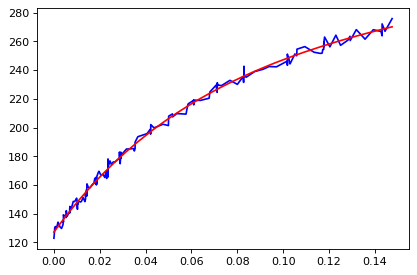

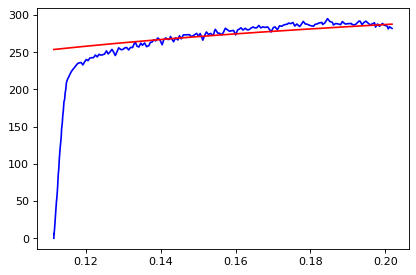

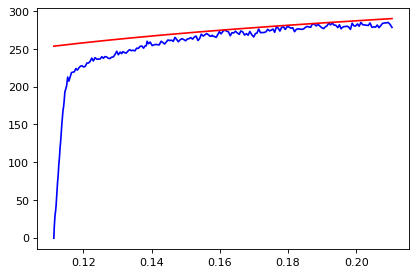

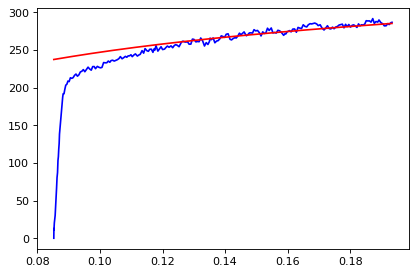

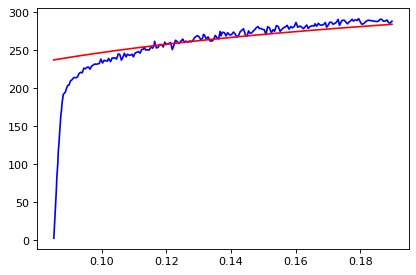

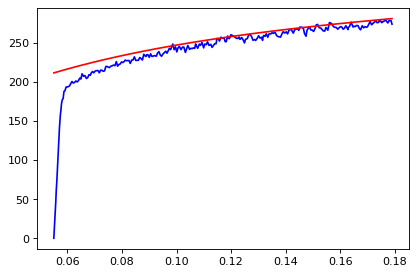

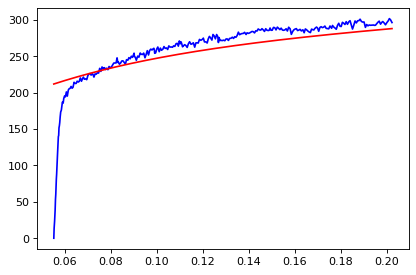

In [4]:
CPLaw = "PH"
curveIndex = 4



# According to Ureta
tau0 = 127.2 
tau1 = 124.2 
theta0 = 2203 
theta1 = 203.5 

# y = tau0 + (tau1 + theta1 * x) * (1 - exp(- x * abs(theta0/tau1)))
for loading in loadings:
    figure(figsize=(6, 4), dpi=80)
    currentPath = f"targets/RVE_1_40_D/PH/{loading}/{CPLaw}{curveIndex}.xlsx"
    trueCurve = preprocessExperimentalTrue(currentPath, True)
    trueStrain = trueCurve["strain"]
    trueStress = trueCurve["stress"] 
    fittedStress = preprocessSwiftVoceHardening(trueStrain, tau0, tau1, theta0, theta1)["stress"]
    plt.plot(trueStrain, trueStress, c='blue', label="Experimental curve")
    plt.plot(trueStrain, fittedStress, c='red', label="Fitted curve")




In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math

paramsFormatted = {
    "PH": {
        "a": "a", 
        "gdot0": "γ̇₀", 
        "h0": "h₀", 
        "n": "n", 
        "tau0": "τ₀", 
        "tausat": "τₛₐₜ",
        "self": "self", 
        "coplanar": "coplanar", 
        "collinear": "collinear", 
        "orthogonal": "orthogonal", 
        "glissile": "glissile", 
        "sessile": "sessile", 
    },
    "DB": {
        "dipole": "d̂α", 
        "islip": "iₛₗᵢₚ", 
        "omega": "Ω", 
        "p": "p", 
        "q": "q", 
        "tausol": "τₛₒₗ",
        "Qs": "Qs",
        "Qc": "Qc",
        "v0": "v₀",
        "rho_e": "ρe",
        "rho_d": "ρd",   
    },
}

loadings = ["linear_uniaxial_RD", 
            "nonlinear_biaxial_RD", 
            "nonlinear_planestrain_RD",  
            "nonlinear_uniaxial_RD",   
            "nonlinear_biaxial_TD", 
            "nonlinear_planestrain_TD",          
            "nonlinear_uniaxial_TD"]

indexLoading = {
    "linear_uniaxial_RD": (0,0), 
    "nonlinear_biaxial_RD": (1,0), 
    "nonlinear_biaxial_TD": (1,1),     
    "nonlinear_planestrain_RD": (2,0),     
    "nonlinear_planestrain_TD": (2,1),     
    "nonlinear_uniaxial_RD": (3,0), 
    "nonlinear_uniaxial_TD": (3,1),
}


parameterTypes = {
    "PH": {
        "large_yieldingParams":  ["tau0"],
        "small_yieldingParams": [],
        "large_hardeningParams": ["a", "h0", "tausat", "self"],
        "small_hardeningParams": ["coplanar", "collinear", "orthogonal", "glissile", "sessile"]
    },
    "DB": {
        "large_yieldingParams":  ["tausol, Qs, rho_e"],
        "small_yieldingParams": ["p, q, v0"],
        "large_hardeningParams": ["dipole", "islip", "omega", "Qc"],
        "small_hardeningParams": []
    }
}

standardColors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]
print(standardColors)

['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']


# No stage finished yet

FileNotFoundError: [Errno 2] No such file or directory: 'targets/RVE_1_40_D/DB/linear_uniaxial_RD/DB4_process.npy'

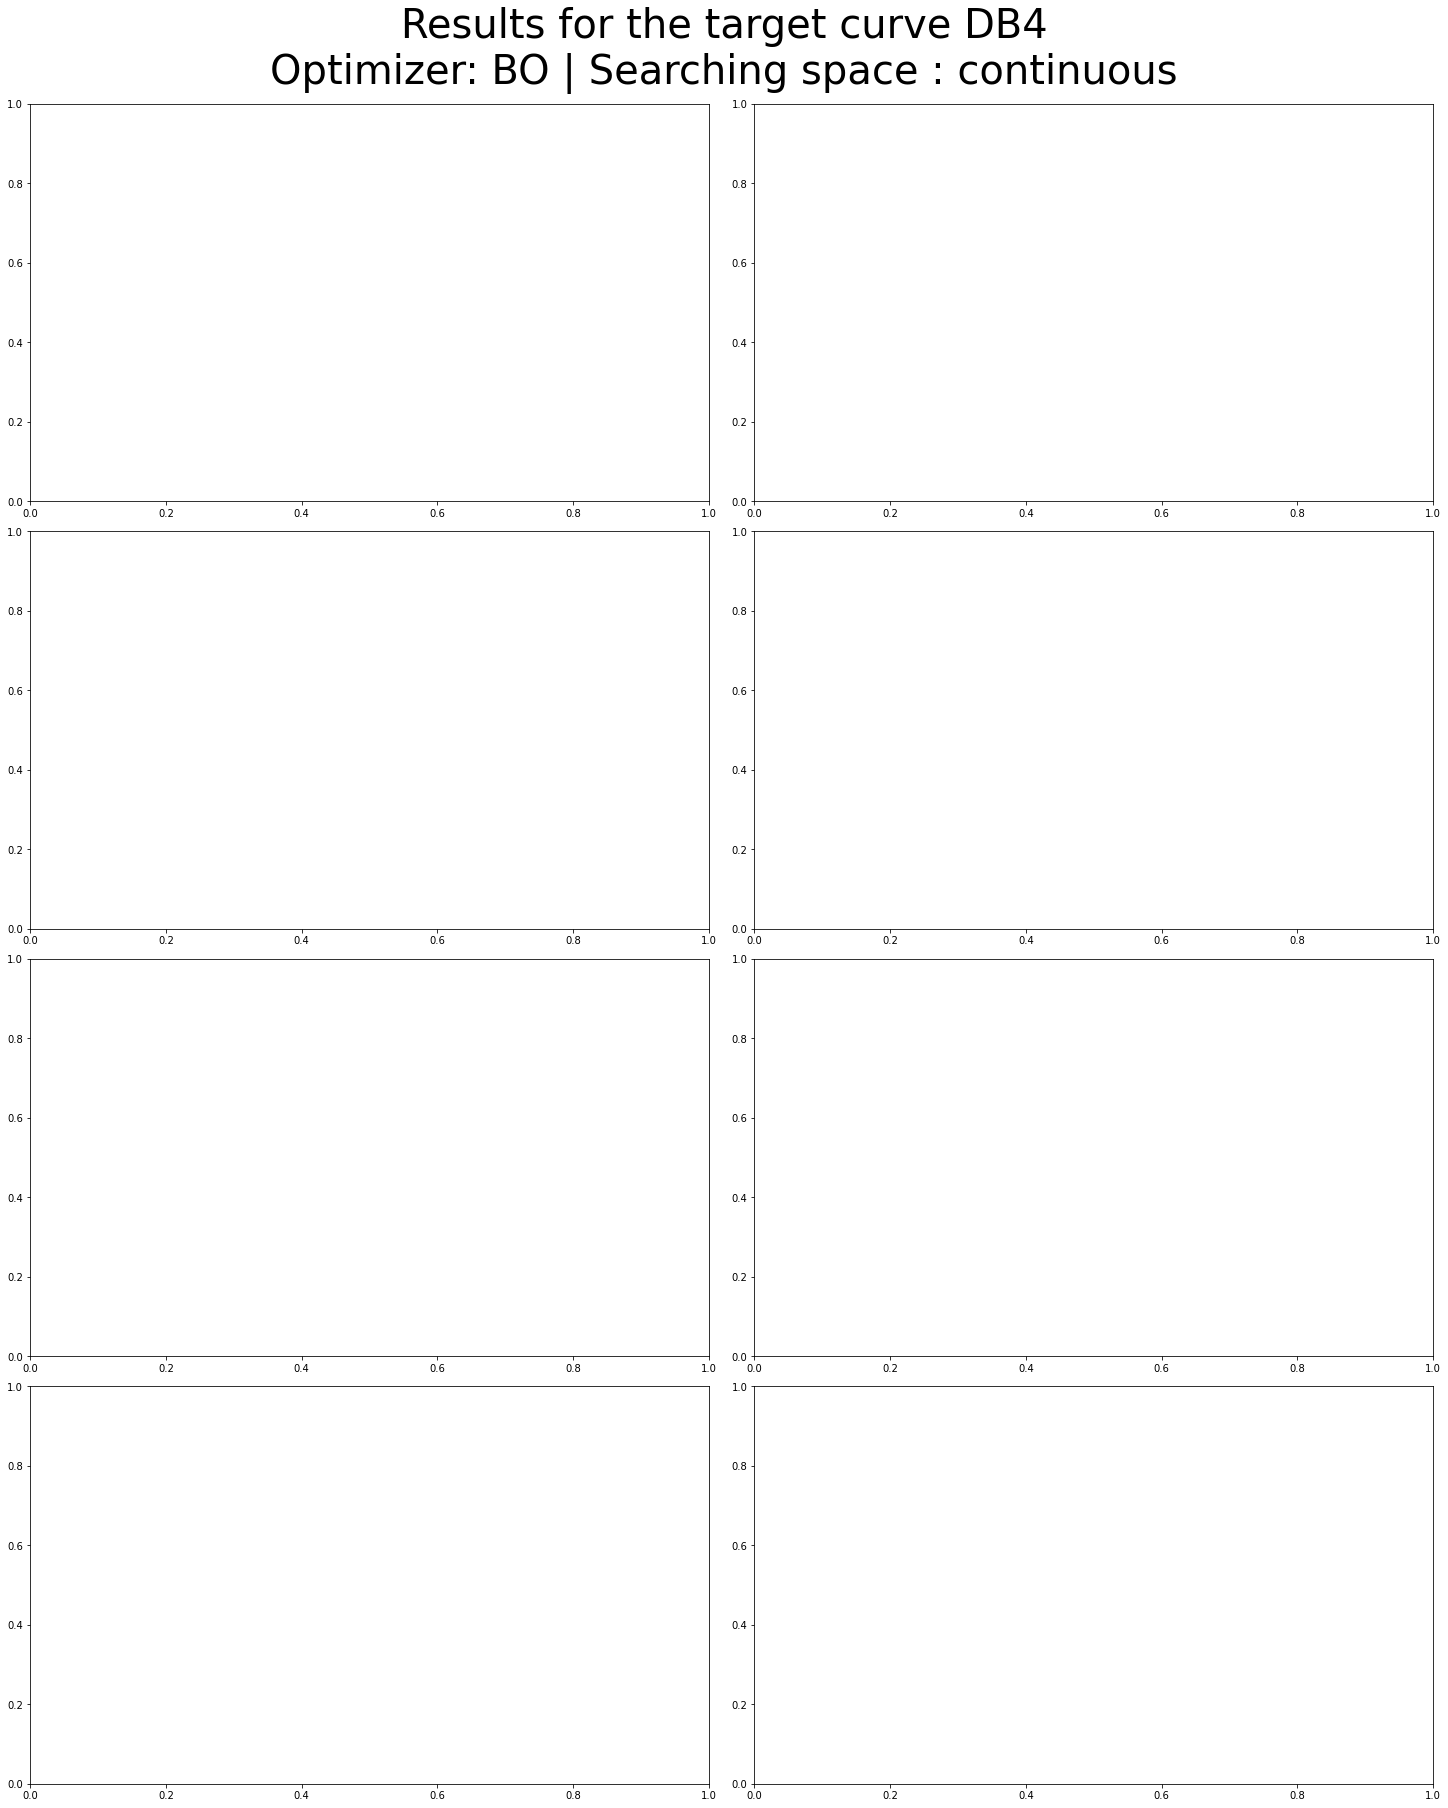

In [20]:
material = "RVE_1_40_D"
curveIndex = 4
CPLaw = "DB"
optimizer = "BO"
searchingSpace = "continuous"
roundingDecimals = 5

if CPLaw == "PH":
    parameterRows = [r"$a$", 
                    r"$h_0$", 
                    r"$\tau_0$", 
                    r"$\tau_{sat}$", 
                    r"$self$", 
                    r"$coplanar$", 
                    r"$collinear$", 
                    r"$orthogonal$", 
                    r"$glissile$", 
                    r"$sessile$"]
elif CPLaw == "DB":
    parameterRows = [r"$\hat{d}^\alpha$", 
                    r"$i_{slip}$", 
                    r"$\Omega$", 
                    r"$p$", 
                    r"$q$", 
                    r"$\tau_{sol}$", 
                    r"$Q_s$", 
                    r"$Q_c$", 
                    r"$v_0$", 
                    r"$\rho_e$"]

resultPath = f"results/{material}/{CPLaw}/{CPLaw}{curveIndex}_{optimizer}_{searchingSpace}"
stage_CurvesList = np.load(f"{resultPath}/stage_CurvesList.npy", allow_pickle=True).tolist()[-2:-1]


parameterValues = list([stageCurves["parameters_tuple"] for stageCurves in stage_CurvesList])

iterationColumns = []
paramValues2D = []

numberOfIterations = len(parameterValues) 
repeatedCycles = math.ceil(numberOfIterations/10) 
columnColors = standardColors * repeatedCycles


for iteration in range(1, len(stage_CurvesList) + 1):
    iterationColumns.append(f"Iter {iteration}")

for tupleParams in parameterValues:
    paramValues = []
    dictParams = dict(tupleParams)
    for param in dictParams:
        paramValues.append(round(dictParams[param], roundingDecimals))
    paramValues2D.append(paramValues)

# transposing the matrix
paramValues2D = np.array(paramValues2D).T



size = 22


# Stage 1:
fig, ax = plt.subplots(4,2, figsize=(20,25), constrained_layout=True)

# fig.tight_layout(rect=[0, 0.03, 1, 0.9])
# fig.subplots_adjust(top=0.95)

fig.suptitle(f'Results for the target curve {CPLaw}{curveIndex}\nOptimizer: {optimizer} | Searching space : {searchingSpace}', fontsize=40)


curveType = "process"
for loading in loadings:
    iteration = 1
    pathTarget = f"targets/{material}/{CPLaw}/{loading}/{CPLaw}{curveIndex}_{curveType}.npy"
    target_processCurve = np.load(pathTarget, allow_pickle=True).tolist()
    i = indexLoading[loading][0]
    j = indexLoading[loading][1]
    ax[i][j].plot(target_processCurve["strain"], target_processCurve["stress"], color = "k", linewidth=3, alpha=1, label=f"Target\ncurve")
    for stageCurves in stage_CurvesList:
        ax[i][j].plot(stageCurves[curveType][loading]["strain"], stageCurves[curveType][loading]["stress"],  linewidth=3, alpha=1, label=f"Iter {iteration}")
        iteration += 1
        
        ax[i][j].set_xlim(right = 0.27)
        ax[i][j].set_ylim(bottom = 90)
        ax[i][j].tick_params(axis='x', labelsize= size)
        ax[i][j].tick_params(axis='y', labelsize= size)
        ax[i][j].set_ylabel('Stress (MPa)', size= size)
        ax[i][j].set_xlabel("Strain (-)", size= size)
        ax[i][j].set_title(f"{loading} loading", size= 5/4 * size)
        legend = ax[i][j].legend(loc=4, frameon=False, fontsize= 3/4 * size, ncol=2) #, shadow =True, framealpha=1)
        # plt.grid()
        legend.get_frame().set_linewidth(0.0)

ax[0][1].axis('tight')
ax[0][1].axis('off')
table = ax[0][1].table(cellText=paramValues2D, 
                        colLabels=iterationColumns, 
                        rowLabels=parameterRows, 
                        loc='upper center', 
                        cellLoc='center', 
                        colLoc="center",
                        rowLoc="center",
                        colWidths=[0.1 for x in iterationColumns],
                        colColours= columnColors, 
                        fontsize=30)
ax[0][1].set_title(f"Parameter values", size= 5/4 * size)
table.auto_set_column_width(col=iterationColumns)
table.auto_set_font_size(False)
table.set_fontsize(15)
table.scale(2, 2)

plt.show()

# Stage 1 Optimization

[(('a', 1.976989), ('h0', 1116.058029), ('tau0', 190.99436), ('tausat', 568.715858), ('self', 0.936469), ('coplanar', 1.770886), ('collinear', 3.801902), ('orthogonal', 0.110056), ('glissile', 1.445223), ('sessile', 0.967985))]
1
[[190.99436]]
['Iter 1']
['τ₀']


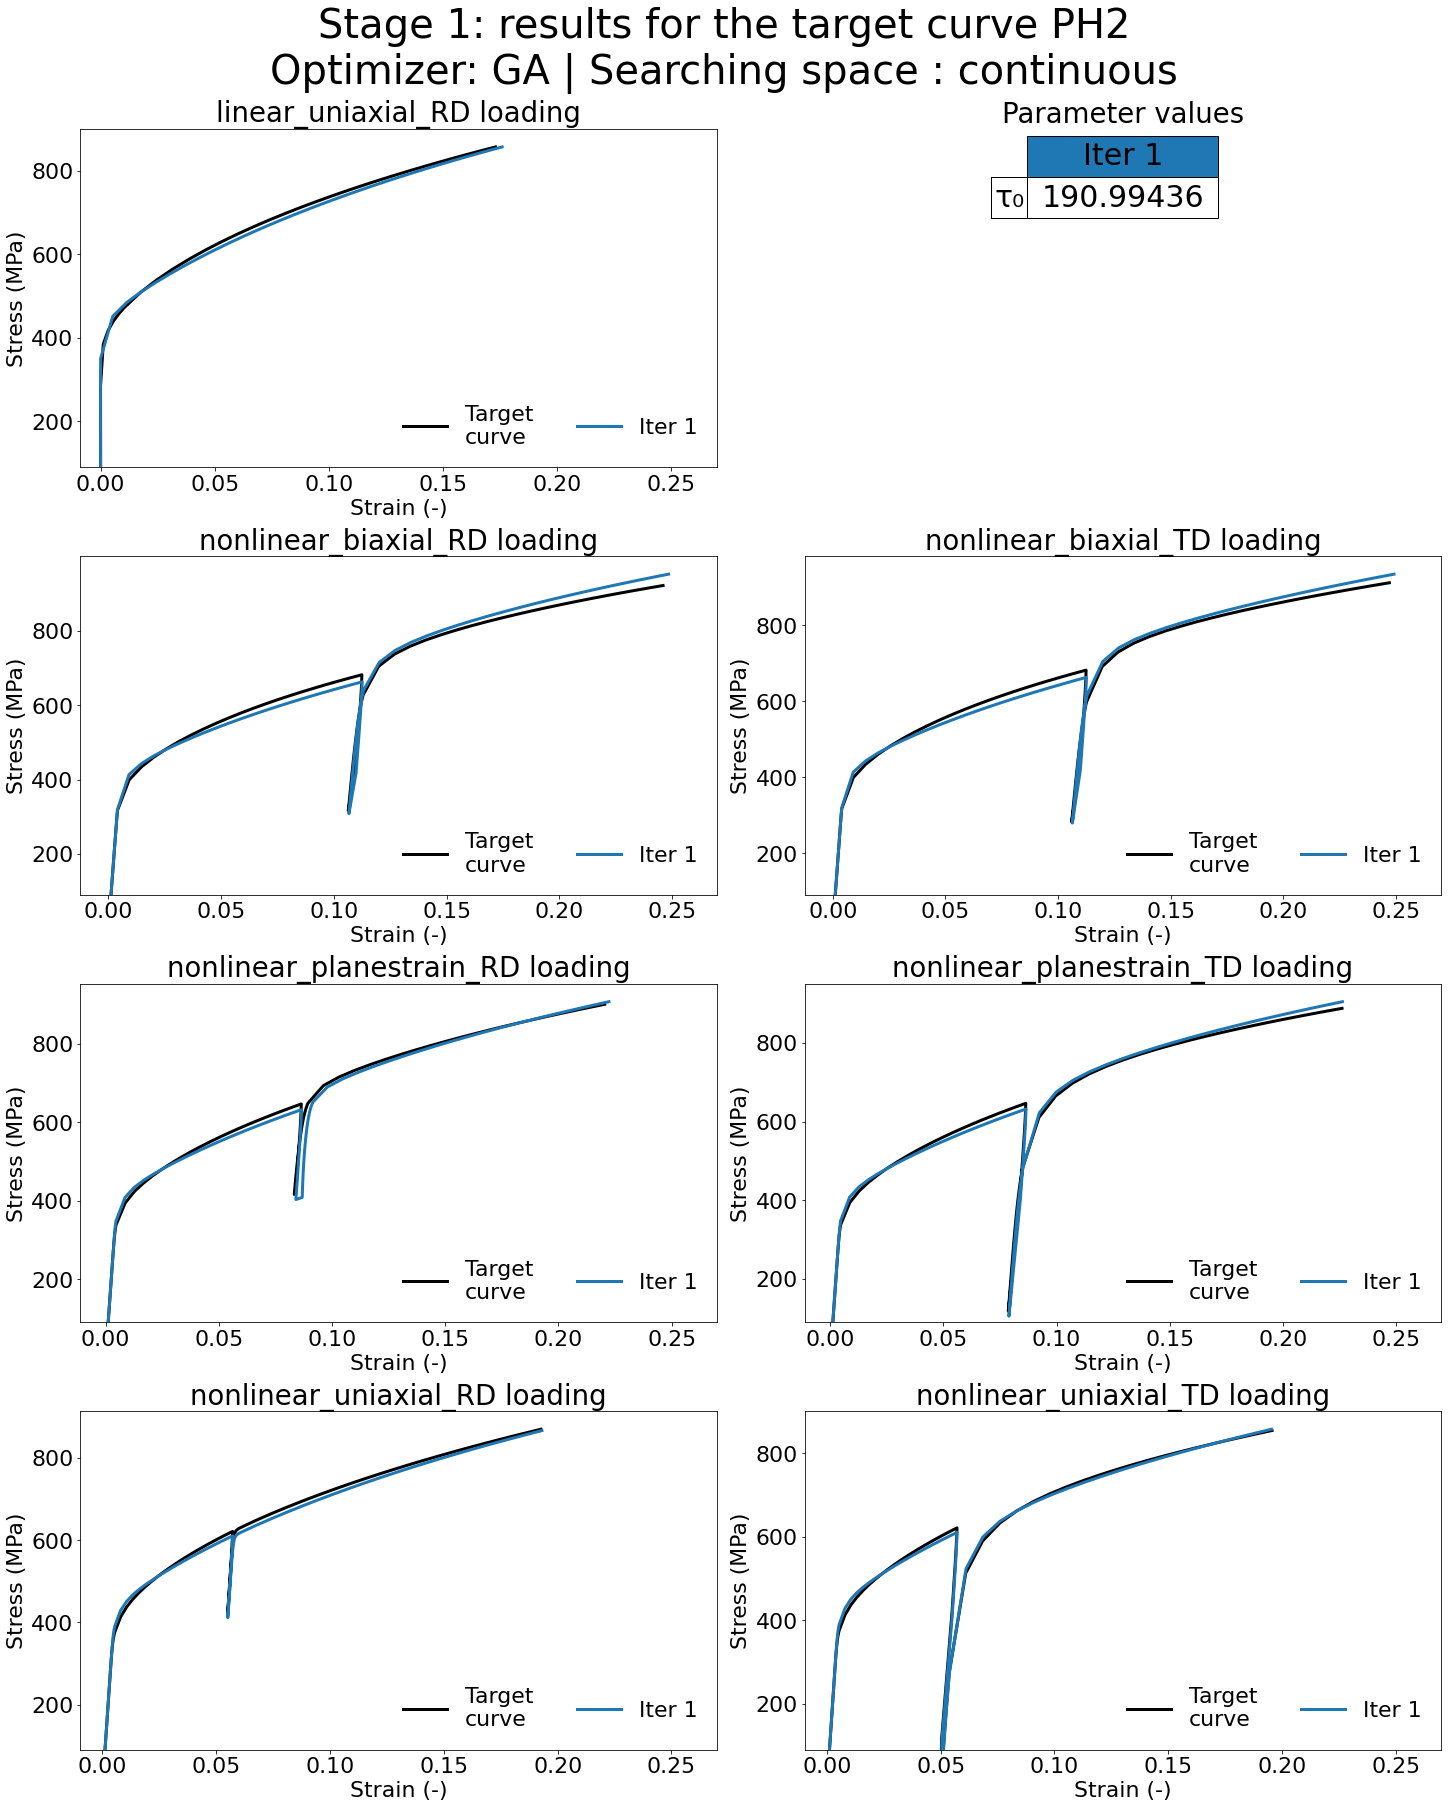

In [234]:
material = "RVE_1_40_D"
curveIndex = 2
CPLaw = "PH"
optimizer = "GA"
searchingSpace = "continuous"


resultPath = f"results/{material}/{CPLaw}/{CPLaw}{curveIndex}_{optimizer}_{searchingSpace}"
iteration_processCurves = np.load(f"{resultPath}/iteration_processCurves.npy", allow_pickle=True).tolist()
reverse_iteration_processCurves = np.load(f"{resultPath}/reverse_iteration_processCurves.npy", allow_pickle=True).tolist()
size = 22


if os.path.exists(f"{resultPath}/stage1_curves.npy"):
    stage1_curves = np.load(f"{resultPath}/stage1_curves.npy", allow_pickle=True).tolist()
    succeeding_iteration = stage1_curves["succeeding_iteration"]

# Stage 1:
fig, ax = plt.subplots(4,2, figsize=(20,25), constrained_layout=True)

# fig.tight_layout(rect=[0, 0.03, 1, 0.9])
# fig.subplots_adjust(top=0.95)


colors = [""]
fig.suptitle(f'Stage 1: results for the target curve {CPLaw}{curveIndex}\nOptimizer: {optimizer} | Searching space : {searchingSpace}', fontsize=40)

numberOfIterations = succeeding_iteration - 0
repeatedCycles = math.ceil(numberOfIterations/10) 
columnColors = standardColors * repeatedCycles


parameterValues = list(reverse_iteration_processCurves.keys())[0:succeeding_iteration]
print(parameterValues)
parameterRows = []
iterationColumns = []
paramValues2D = []

for parameter in parameterTypes[CPLaw]["large_yieldingParams"]:
    parameterRows.append(paramsFormatted[CPLaw][parameter])

for iteration in range(1, succeeding_iteration + 1):
    iterationColumns.append(f"Iter {iteration}")

for tupleParams in parameterValues:
    paramValues = []
    dictParams = dict(tupleParams)
    for targetParam in parameterTypes[CPLaw]["large_yieldingParams"]:
        if targetParam in dictParams:
            paramValues.append(dictParams[targetParam])
    paramValues2D.append(paramValues)

# transposing the matrix
# paramValues2D = np.array(paramValues2D).T

print(succeeding_iteration)
print(paramValues2D)
print(iterationColumns)
print(parameterRows)

for loading in loadings:
    iteration = 1
    loading_data =  dict(list(iteration_processCurves[loading].items())[0:succeeding_iteration]) 
    pathTarget = f"targets/{material}/{CPLaw}/{loading}/{CPLaw}{curveIndex}_process.npy"
    target_processCurve = np.load(pathTarget, allow_pickle=True).tolist() 
    i = indexLoading[loading][0]
    j = indexLoading[loading][1]
    ax[i][j].plot(target_processCurve["strain"], target_processCurve["stress"], color = "k", linewidth=3, alpha=1, label=f"Target\ncurve")
    for (parameters, strainstress) in loading_data.items():

        ax[i][j].plot(strainstress["strain"], strainstress["stress"],  linewidth=3, alpha=1, label=f"Iter {iteration}")
        iteration += 1
        
        ax[i][j].set_xlim(right = 0.27)
        ax[i][j].set_ylim(bottom = 90)
        ax[i][j].tick_params(axis='x', labelsize= size)
        ax[i][j].tick_params(axis='y', labelsize= size)
        ax[i][j].set_ylabel('Stress (MPa)', size= size)
        ax[i][j].set_xlabel("Strain (-)", size= size)
        ax[i][j].set_title(f"{loading} loading", size= 5/4 * size)
        legend = ax[i][j].legend(loc=4, frameon=False, fontsize= size, ncol=2) #, shadow =True, framealpha=1)
        # plt.grid()
        legend.get_frame().set_linewidth(0.0)

ax[0][1].axis('tight')
ax[0][1].axis('off')
table = ax[0][1].table(cellText=paramValues2D, 
                        colLabels=iterationColumns, 
                        rowLabels=parameterRows, 
                        loc='upper center', 
                        cellLoc='center', 
                        colLoc="center",
                        rowLoc="center",
                        colWidths=[0.1 for x in iterationColumns],
                        colColours= columnColors, 
                        fontsize=30)
ax[0][1].set_title(f"Parameter values", size= 5/4 * size)
table.auto_set_column_width(col=iterationColumns)
table.auto_set_font_size(False)
table.set_fontsize(30)
table.scale(3, 3)
# paramatersList = list(dict(parameters).values())
# parameters2D.append(paramatersList)
# iterations.append(f"Iter {counter}")
# counter += 1
# print(iterations)
# print(parameters2D)
# parameters2D = np.array(parameters2D).T

# 


# clust_data = np.random.randint(1,10, (10,5))

# #axs[0].plot(clust_data[:,0],clust_data[:,1])

# axs[i][j].axis('tight')
# axs[i][j].axis('off')
# the_table = axs[1].table(cellText=parameters2D,colLabels=iterations, rowLabels=parameters, loc='center', cellLoc='center', fontsize=30)


plt.show()